In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import ast
import glob
import tempfile
import os


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

np.random.seed(0)

In [3]:
IMAGE_LOC = '../HMPDataset/'
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0 and "MODEL" not in i]

In [4]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

In [5]:
data = read_data(activity_list)
data_ts = get_acceleration_timeseries(data)

In [6]:
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {'mean_over_median': 0, #dimensionless            
                    'std_over_median': 0, #dimensionless            
                    'length': length,
                    'kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {'mean_over_median': mean/median, #dimensionless            
            'std_over_median': std/median, #dimensionless            
            'length': length,
            'kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    model = None
    return features

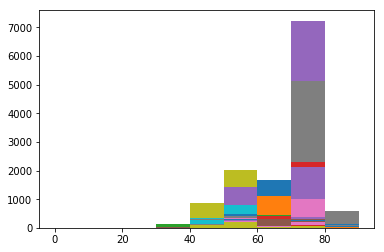

In [7]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_ts: #slow, should parallelize
    for elem in data_ts[k]:
        df.append(featurize_stats(elem, bins))
        labels.append(k)

In [8]:
df = pd.DataFrame(df)
df['label'] = labels 
train_df, test_df = train_test_split(df, train_size=0.75)

/home/mcliffor/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
one_hot = np.array(train_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
train_label = one_hot_encoder.fit_transform(integer_encoder)

one_hot = np.array(test_df['label'])
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(one_hot)
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoder = integer_encoder.reshape(len(integer_encoder),1)
test_label = one_hot_encoder.fit_transform(integer_encoder)

In [10]:
model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(13,)),
    keras.layers.Dense(14, activation=tf.nn.log_softmax)
]) 

In [11]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)

In [12]:
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

In [13]:
history = model.fit( train_df.drop('label', axis=1), train_label, epochs=80000, batch_size=629, verbose=0)

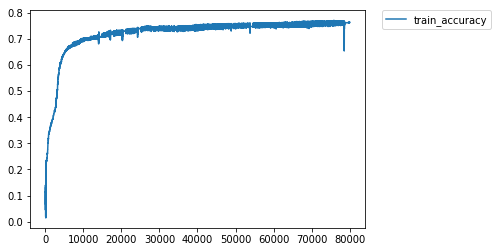

In [14]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_label)

print('Test accuracy:', test_acc)

210/210 [==============================] - 0s 201us/step
Test accuracy: 0.757142854872204


In [25]:
# Added code snippet from https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
# to save model for TF-serving

save = False

if save == True:
    MODEL_DIR = tempfile.gettempdir()
    version = 1
    export_path = os.path.join(MODEL_DIR, str(version))
    print('export_path = {}\n'.format(export_path))
    if os.path.isdir(export_path):
        print('\nAlready saved a model, cleaning up\n')
        !rm -r {export_path}

    tf.saved_model.simple_save(
        keras.backend.get_session(),
        export_path,
        inputs={'input_data': model.input},
        outputs={t.name:t for t in model.outputs})

    print('\nSaved model:')
    !ls -l {export_path}